In [1]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import os

C:\ProgramData\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def fetch_acq_files(user_name, acquistion_folder, device_name):
    path_name = os.path.join('~', 'Desktop', 'acqBIT')   
    path = os.path.expanduser(os.path.join(path_name, user_name, acquisition_folder,device_name))
    list_files = os.listdir(path)
    acq_files = [os.path.join(path, path_file)  for path_file in list_files if '.h5' in path_file]
    return acq_files

def get_channel_from_files(acq_files, channel_name):
    channels = []
    for file_path in acq_files:
        with h5.File(file_path, 'r') as f:
            r_group = f[f.keys()[0]]
            channel = r_group[channel_name][:]
            channels.append(channel)
    return channels

In [3]:
# create toy sine wave 
n = 36*1000
t_s = np.linspace(0, 100, n).reshape(n, 1)
print t_s
f = 1
xi = np.pi
K = 255
signal = K * np.tan(2*f*np.pi*t_s + xi)

[[0.00000000e+00]
 [2.77785494e-03]
 [5.55570988e-03]
 ...
 [9.99944443e+01]
 [9.99972221e+01]
 [1.00000000e+02]]


In [4]:
ndsignal = np.array([signal[:, 0] for i in xrange(0, 11)], copy=False).T

In [5]:
ndsignal.shape

(36000L, 11L)

In [15]:
## Real signal
# Fetch created directory
user_name = 'New User'
acquisition_folder = '20190225-205628'
device_name = 'VR EDA'
acq_files = fetch_acq_files(user_name, acquisition_folder, device_name)[0:1]

# Get sequence number for acquisition
# Set names of the datasets, order according to the data array
nseq_dset_names = ['raw/nSeq']
digital_dset_names = ['digital/digital_{}'.format(dgNr + 1) for dgNr in xrange(0, 4)]
analog_dset_names = ['raw/channel_{}'.format(chNr + 1)  for chNr in xrange(0, 6)]

array = []
for channel_name in nseq_dset_names + digital_dset_names + analog_dset_names:
    array.append(get_channel_from_files(acq_files, channel_name)[0])

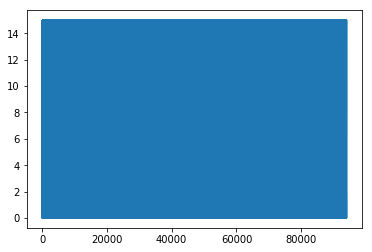

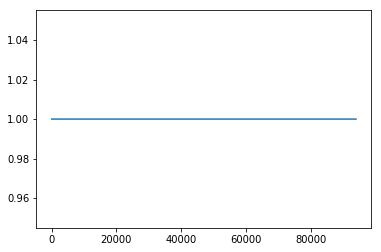

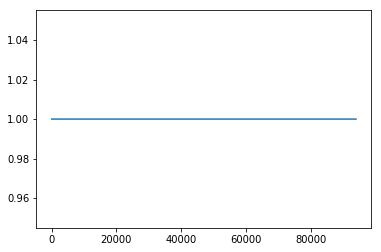

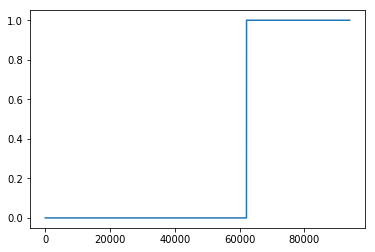

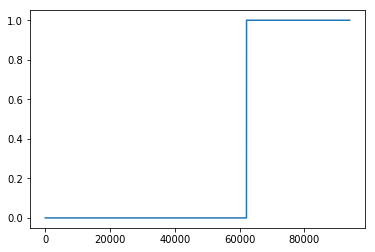

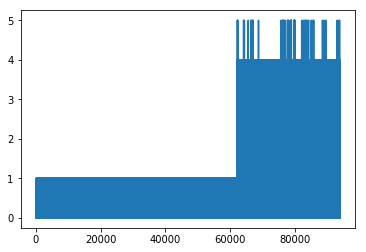

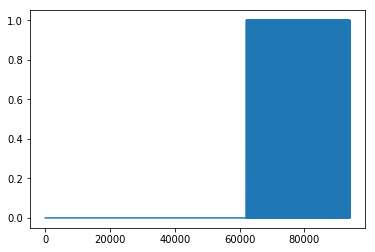

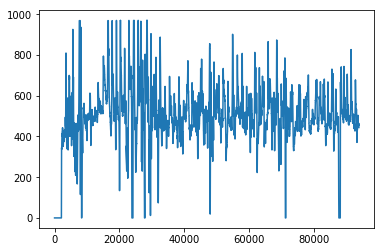

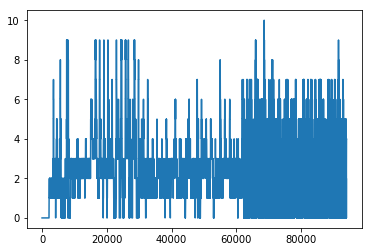

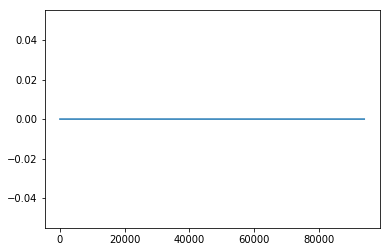

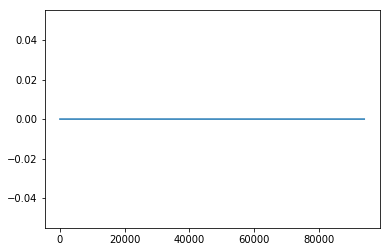

In [16]:
for channel in array:
    plt.figure()
    plt.plot(channel)

In [17]:
ndsignal = np.concatenate(array, axis=1)
print ndsignal.shape

(94000L, 11L)


In [9]:
def _write_acq_channel(r_group, channelName, channelSignal):
    """
    Write 1D signal from acquistion to the end of h5 dataset
    """
    # Write acquisition channel to h5 dset
    nSamples = channelSignal.shape[0]
    dset = r_group[channelName]
    nSamples_ds = dset.shape[0]
    dset.resize((nSamples_ds + nSamples, 1))
    dset[-nSamples:, 0] = channelSignal


def write_h5file(r_group, acqChannels, ndsignal):
    """ 
    Utility function to open and write to a previously opened h5 file for the acquisition
    """
    # Set names of the datasets, order according to the data array
    nseq_dset_names = ['raw/nSeq']
    digital_dset_names = ['digital/digital_{}'.format(dgNr + 1) for dgNr in xrange(0, 4)]
    analog_dset_names = ['raw/channel_{}'.format(chNr)  for chNr in acqChannels]
    dset_names = nseq_dset_names + digital_dset_names + analog_dset_names

    # Set the datasets on the file
    for i, dset_name in enumerate(dset_names):
        _write_acq_channel(r_group, dset_name, ndsignal[:, i])

        
def overwrite_dsets(r_group):

    # Set names of the datasets, order according to the data array
    nseq_dset_names = ['raw/nSeq']
    digital_dset_names = ['digital/digital_{}'.format(dgNr + 1) for dgNr in xrange(0, 4)]
    analog_dset_names = ['raw/channel_{}'.format(chNr + 1)  for chNr in xrange(0, 6)]
    dset_names = nseq_dset_names + digital_dset_names + analog_dset_names

    # Set the datasets on the file
    for dset_name in dset_names:
        print dset_name
        attrs = r_group[dset_name].attrs
        del r_group[dset_name]
        r_group.create_dataset(dset_name, 
                               dtype='uint16', shape=(0, 1), 
                               maxshape=(None, 1), chunks=(1024, 1))

        for k in attrs.keys():
            # Set attributes of the new dataset
            r_group[dset_name].attrs[k] = attrs[k]
                        

def open_h5file_os(path_file):
    dummy_path_file = 'C:\\Users\\franciscosargo\\Desktop\\opensignals_201604120230_2019-02-03_13-53-11.h5'
    ## Copy the contents from the dummy file
    with h5.File(dummy_path_file, 'r+') as dummy_f, h5.File(path_file, 'w') as f:
        r_group = dummy_f[dummy_f.keys()[0]]
        group_id = f.require_group('/')
        dummy_f.copy(r_group, group_id)

            
def write_sp_h5file(r_goup, acqChannels, support):
    digital_support_dset_names = ['dig_channel_{}'.format(dgNr) for dgNr in xrange(1, 5)]
    analog_dset_support_names = ['channel_{}'.format(chNr)  for chNr in acqChannels]
    for l, level in enumerate([10, 100, 1000]):
        for i, channel_name in enumerate(digital_support_dset_names + analog_dset_support_names):
                
                del r_group['support/level_{}/{}/Mx'.format(level, channel_name)]
                support_arr = support[l][0][:, i:i+1]
                r_group.create_dataset('support/level_{}/{}/Mx'.format(level, channel_name), dtype='uint16',
                                        data=support_arr)
                
                del r_group['support/level_{}/{}/mx'.format(level, channel_name)]
                support_arr = support[l][1][:, i:i+1]
                r_group.create_dataset('support/level_{}/{}/mx'.format(level, channel_name), dtype='uint16',
                                        data=support_arr)
                
                del r_group['support/level_{}/{}/mean'.format(level, channel_name)]
                support_arr = support[l][2][:, i:i+1]
                r_group.create_dataset('support/level_{}/{}/mean'.format(level, channel_name), dtype='float32',
                                        data=support_arr)
                
                del r_group['support/level_{}/{}/mean_x2'.format(level, channel_name)]
                support_arr = support[l][3][:, i:i+1]
                r_group.create_dataset('support/level_{}/{}/mean_x2'.format(level, channel_name), dtype='uint32',
                                        data=support_arr)
                
                del r_group['support/level_{}/{}/sd'.format(level, channel_name)]
                support_arr = support[l][4][:, i:i+1]
                r_group.create_dataset('support/level_{}/{}/sd'.format(level, channel_name), dtype='float32',
                                        data=support_arr)
                
                del r_group['support/level_{}/{}/t'.format(level, channel_name)]
                support_arr = np.array(support[l][5], copy=False).reshape(len(support[l][5]), 1)

                r_group.create_dataset('support/level_{}/{}/t'.format(level, channel_name), dtype='uint32',
                                        data=support_arr)


In [18]:
path_file = 'C:\\Users\\franciscosargo\\Desktop\\another_good_file.h5'
open_h5file_os(path_file)

with h5.File(path_file) as f:
    acqChannels = [1, 2, 3, 4, 5, 6]
    r_group = f[f.keys()[0]]
    overwrite_dsets(r_group)
    write_h5file(r_group, acqChannels, ndsignal)
    support = compute_support(ndsignal)
    write_sp_h5file(r_group, acqChannels, support)
    
    r_group.attrs['nsamples'] = len(ndsignal)

raw/nSeq
digital/digital_1
digital/digital_2
digital/digital_3
digital/digital_4
raw/channel_1
raw/channel_2
raw/channel_3
raw/channel_4
raw/channel_5
raw/channel_6


In [11]:
def _compute_support(level, ndsignal, n, p):
    N = n/level
    ndarray = ndsignal.reshape(N, level, p)
    Mx = ndarray.max(axis=1)
    mx = ndarray.min(axis=1)
    mean = np.mean(ndarray, axis=1)
    mean_x2 = np.mean(ndarray, axis=1)**2
    sd = np.std(ndarray, axis=1)
    t = list(xrange(0, n, level))
    return [Mx, mx, mean, mean_x2, sd, t]


def compute_support(ndsignal):
    ndsignal = ndsignal[:, 1:]
    n = ndsignal.shape[0]
    p = ndsignal.shape[1]
    return [_compute_support(level, ndsignal, n, p) for level in [10, 100, 1000]]

In [ ]:
a = ndsignal[:, 1:]
level = 100
n = a.shape[0]
p = a.shape[1]
N  = n/level

print '1' + '-'*24
print a
print a.shape
print '-'*25

print ''
print '2' + '-'*24
w_a = a.reshape(N, level, p)
print w_a
print w_a.shape
print '-'*25

print ''
print '3' + '-'*24
w = w_a[0, :, :]
print w
print w.shape
print '-'*25

print ''
print '4' + '-'*24
Mx_w = w.max(axis=0)
print Mx_w
print Mx_w.shape
print '-'*25

print ''
print '5' + '-'*24
Mx_w_a = w_a.max(axis=1)
print Mx_w_a
print Mx_w_a.shape
print '-'*25